In [1]:
import numpy as np
from qibo.models import Circuit
from qibo import gates,models
from scipy import sparse
from scipy.sparse import csr_matrix
from scipy.sparse import csc_matrix
from scipy.sparse.linalg import inv
import matplotlib.pylab as plt

# Fermionic FT class

In [2]:
#Class fermionic FT: creates the qibo quantum circuit to perform the fermionic FT. 

#inputs:
    #Nspin --> number of Qbits targets to perform the fermionic FT. It has to be a power of two 2**m
    #nqext--> In the case wants to integrate the fermionic FT in a larger circuit, the number of Qbits of this larger circuit. 
    #         by default is None, the argument is optional only. However, in the case it is specify, one must then add the 
    #         qlistext input.
    #qlistext--> List where the fermionic FT circuit will be add in the large circuit. The len of this list must be equal as Nspin
    #sort: By default is False and then the k states are sort as: 0,n/2 ;1,-(n/2)+1;2,-(n/2)+2;...;n/2-1,-1.
    #      If sort=True then we add additional fermionic SWAP circuit and the final order of the k states is:
    #      0,1,2,3,...,n/2,-n/2+1,-n/2+2,...,-1
    


class fermionicFT:
    def __init__(self,Nspin,nqext=None,qlistext=None,sort=False):
        #obtain the number of qbits we are using
        self.numq=Nspin
        #if the number of qbits is not a power of two or different from 0, rise an error
        if not(self.numq & (self.numq-1) == 0) and self.numq != 0:
            raise ValueError("The number of qbits is not a power of 2")
        
        #create a list with the qbits used in the circuit
        qbit_list=np.arange(0,self.numq)
        
        #compute which power of 2 is it
        self.two_power=int(np.log2(self.numq))
        #call the divideqbit method
        self.divideqbit(qbit_list)
        #call the call the initcirc method
        self.initcirc()
        #call the nextcirc1 method
        self.nextcirc1()
        #call the finalcirc method
        self.finalcirc()
        
        #if sort==True then call the sortFT method
        if sort==True:
            self.sortFT()
        
        #if nqext==None and qlistext==None then the final qc is self.circ0
        if nqext==None and qlistext==None:
            smallqc=self.circ0
            self.fermFTqc=smallqc
        
        #if the user add a qlistext but none the nqext raise and error
        elif nqext==None and not qlistext==None:
            raise ValueError("Specify both, the number of qbits of the large circuit(nqext)and the list of the qbits you want to use (qlistext)")
        
        ##if the user add the nqext but none the qlistext raise and error
        elif not nqext==None and qlistext==None:
            raise ValueError("Specify both, the number of qbits of the large circuit(nqext)and the list of the qbits you want to use (qlistext)")
        
        # if the user specify both, nqext and qlistext, then add the FTcircuit on the specified qbits from a large one circuit 
        else:
            largeqc=Circuit(nqext)
            smallqc=self.circ0
            largeqc.add(smallqc.on_qubits(*qlistext))
            self.fermFTqc=largeqc
            
            
        
        
        
    #divideqbit: divide the input qbit list of n=2**m into lists of 2**i where l goes from 2 to m  
            # qlist -->  input qbit list pass from the user       
    #outputs: 
            # self.divqbit: list with the arrays of the segmented new qbit list. The new output contain first the 2**2 lists  
    def divideqbit(self,qlist):
        #create the self.divqbit as an empty list
        self.divqbit=[]
        #loop to create the new lists with a length of 2**i
        for i in range(2,self.two_power+1):
            #length of the new list
            times=2**i
            #compute the number of lists needed to encode all the qbits for the original list
            miter=int(self.numq/times)
            # loop to save all the original qbits in the new lists of length 2**i
            for j in range(0,miter):
                #save the original qbits in the new list
                newqlist=qlist[times*j:times*(j+1)]
                #append it to the output variable
                self.divqbit.append(newqlist)
    
    
    #initcirc: prepare the initial fSWAP circuit   
            
    #outputs: 
            # self.circ0: Circuit with the fSWAPS, is the first part of the FT circuit
    def initcirc(self):
        #create a circuit with the same number of qbits as the input user qbit list
        self.circ0=Circuit(self.numq)
        #inverse the order of self.divqbit
        newlist=self.divqbit[::-1]
        #explore all the list in newlist
        for i in newlist:
            #create a circuit with the same number of qbits as the input user qbit list
            qclarge=Circuit(self.numq)
            #the number of points used for the FT
            n=len(i)
            #Create the FSWAP circuit corresponding to n qbits
            qcsmall=self.circfSWAP.fSWAPSFT(n)
            #add the small circuit to the large one in the qbits inside our list
            qclarge.add(qcsmall.on_qubits(*i))
            #sum this new circuit to the existent ones
            self.circ0+=qclarge
    
    #nextcirc1: add the 2 qbit fFT in the circuit in all qbits (in this case the 2 qbit FT corresponds to k=0)  
            
    #outputs: 
            # self.circ0: it add the new fFT to the circ0
    def nextcirc1(self):
        #creat a new circuit with the same number of qbits as the input user qbit list
        qc0=Circuit(self.numq)
        #in all the even qbits add the 2-Qbit fermionicFT
        for i in range(0,self.numq,2):
            #add the circuit to the original one
            qc0+=self.circFT.FTkgate(self.numq,i,i+1,0,self.numq)
        #sum the 2-fFT to the self.circ0 circuit
        self.circ0+=qc0
    
    
    #finalcirc: add the rest of the circuit. This corresponds to the additional fermionic SWAPS and the m qbits FT, 
    #           with m from 4 to n
            
    #outputs: 
            # self.circ0: we add the final part to self.circ0
    
    def finalcirc(self):
        #list with the order of self.divqbit
        newlist=self.divqbit
        #explore all the list in newlist
        for i in newlist:
            #create a circuit with the same number of qbits as the input user qbit list
            qclarge=Circuit(self.numq)
            #the number of points used for the FT
            n=len(i)
            #Create the FSWAP circuit corresponding to n qbits
            fSWAPsmall=self.circfSWAP.fSWAPSFT(n)
            #create the inverse swap qbirs
            fSWAPsmallinv=fSWAPsmall.invert()
            #create the small FT            
            FTksmall=self.circFT.joinFT(n)
            #if we are in the last step not add the fSWAPsmall circuit 
            if len(i)==self.numq:
                qcfinsmall=fSWAPsmallinv+FTksmall
            else:
                qcfinsmall=fSWAPsmallinv+FTksmall+fSWAPsmall
            #add the small circuit to the large one in the qbits inside our list
            qclarge.add(qcfinsmall.on_qubits(*i))
            #sum this new circuit to the existent ones
            self.circ0+=qclarge
    
    #sortFT: add an additional fermionic SWAP circuit to sort the k states. 
    #outputs: 
            # self.circ0: we add the additional circuit to self.circ0 
    def sortFT(self):
        #call the static method circfSWAP for the n qbits
        FSWAPorder=self.circfSWAP.fSWAPSFT(self.numq)
        #add this circuit to self.circ0
        self.circ0+=FSWAPorder
        
        
        
    
    
    #___________________________________________________________________________________________________________________#
    class circFT:
        #Function CH:  Creates the gate CH

        #Parameters: 
                # numq -->  Qbits number of the circuit
                # q0 --> the Qbit wich controls the gate
                # q1 --> the targed Qbit

        #outputs: 
                # qc --> Returns a quantum circuit of nq qbits with the CH gate
        @staticmethod   
        def CH(numq,q0,q1):
            #create a circuit with numq qubits
            qc=Circuit(numq)
            #add the conjugate adjoint of S gate to the qbit q1
            qc.add(gates.S(q1).dagger())
            #add the Hadamard gate to qbit q1
            qc.add(gates.H(q1))
            #add the conjugate adjoint T gate to qbit q1
            qc.add(gates.T(q1).dagger())
            #add the CNOT, control qubit is q0 and the target qbit is q1
            qc.add(gates.CNOT(q0,q1))
            #add the T gate to qbit q1
            qc.add(gates.T(q1))
            #add the Hadamard gate to qbit q1
            qc.add(gates.H(q1))
            #add the S gate to the qbit q1
            qc.add(gates.S(q1))
            #return the circuit with the gate CH
            return qc


        #Function CNOT2:  Creates the gate CNOT2 with is a combination of CNOT surrounded by H gates in each Qbit

        #Parameters: 
                # numq -->  Qbits number of the circuit
                # q0 --> the Qbit wich controls the gate
                # q1 --> the targed Qbit

        #outputs: 
                # qc --> Returns a quantum circuit of nq qbits with the CNOT2 gate
        @staticmethod
        def CNOT2(numq,q0,q1):
            #create a circuit with numq qubits
            qc=Circuit(numq)
            #add the Hadamard gate to qbit q0
            qc.add(gates.H(q0))
            #add the Hadamard gate to qbit q1
            qc.add(gates.H(q1))
            #add the CNOT, control qubit is q0 and the target qbit is q1
            qc.add(gates.CNOT(q0,q1))
            #add the Hadamard gate to qbit q0
            qc.add(gates.H(q0))
            #add the Hadamard gate to qbit q1
            qc.add(gates.H(q1))
            #return the circuit with the gate CNOT2
            return qc



        #F2gate: Gate that implement the 2-Qbit fermionic FT, equivalent to general 2-Qbit fermionic FT with k=0.
        #Created by combination of CZinv.CNOT2.CH.CNOT2; CNOT2 is a control NOT surround by H in each qbit.

        #Function F2gate:  creates the circuit which applies the F2 gate

        #Parameters: 
                # numq -->  Qbits number of the circuit
                # q0,q1 --> the Qbits where the gate is applied

        #outputs: 
                # qc --> Returns a quantum circuit of nq Qbits with the FTW gate
        @staticmethod
        def F2gate(numq,q0,q1):
            #call the @staticmethod CNOT2
            circ0=fermionicFT.circFT.CNOT2(numq,q0,q1)
            #call the @staticmethod CH
            circ1=fermionicFT.circFT.CH(numq,q0,q1)
            #create a circuit with numq qubits
            circ2=Circuit(numq)
            #add the CZ gate, control qubit is q0 and the target qbit is q1
            circ2.add(gates.CZ(q0,q1))
            #sum the circuits with the correct order
            qc=circ0+circ1+circ0+circ2
            #return the circuit with the F2gate
            return qc


        #FTphase: Gate that implement the general phase necessary in the general 2-Qbit fermionic FT 
        #Function FTphase:  creates the circuit which applies the FTW gate

        #Parameters: 
                # numq -->  Qbits number of the circuit
                # q0,q1 --> the Qbits where the gate is applied
                # k --> momentum of the fermions. One of the k values possible of the FT
                # n --> number of points used in the fourier transform.
        #outputs: 
                # qc --> Returns a quantum circuit of nq Qbits with the FTphase gate
        @staticmethod
        def FTphase(numq,q0,q1,k,n):
            #compute the angle for the phi gate
            phi=-2*np.pi*k/float(n)
            #create a circuit with numq qubits
            qc=Circuit(numq)
            # add the Qibo u1 gate in qbit q1 , equivalent to Ph gate
            qc.add(gates.U1(q1, phi))
            #return the circuit with the FTphase
            return qc


        #Ftkgate: Gate that implement the generic 2-Qbit fermionic.
        #Function Ftkgate:  creates the circuit which applies the fFT gate

        #Parameters: 
                # numq -->  Qbits number of the circuit
                # q0,q1 --> the Qbits where the gate is applied
                # k --> momentum of the fermions. One of the k values possible of the FT
                # n --> number of points used in the fourier transform.

        #outputs: 
                # qc --> Returns a quantum circuit of nq Qbits with the fFT gate
        @staticmethod
        def FTkgate(numq,q0,q1,k,n):
            #call the @staticmethod FTphase. It creates a circuit with the FTphase
            circ0=fermionicFT.circFT.FTphase(numq,q0,q1,k,n)
            #call the @staticmethod F2gate. It creates a circuit with the F2gate
            circ1=fermionicFT.circFT.F2gate(numq,q0,q1)
            #sum the circuits, the final one applies first the FTW and then the FT0
            qc=circ0+circ1
            #return the final circuit qcf
            return qc
        
        #Function kvalues:  return the k values used for the FT gate

        #Parameters: 
                # numq --> number of points used in the fourier transform.

        #outputs: 
                # klist --> list with the kvalues
        @staticmethod
        def kvalues(numq):
            n=int(numq/2)
            klist0=np.arange((n)-1,-1,-1)
            klist=klist0[::-1]
            return klist
        
        #Function joinFT:  join the fermionicFT gates in a subcircuit of n-qbits with the corresponding k values
        # from 0 to n/2

        #Parameters: 
                # numq --> number of qbits 

        #outputs: 
                # qc --> return the circuit with the corresponding fFT[n,k]
        @staticmethod
        def joinFT(numq):
            qc=Circuit(numq)
            klist=fermionicFT.circFT.kvalues(numq)
            qbit=0
            for k in klist:
                qc+=fermionicFT.circFT.FTkgate(numq,qbit,qbit+1,k,numq)
                qbit+=2
            
            return qc
            
            
            
        
        
    #__________________________________________________________________________________________________________________
    
    
    class circfSWAP:
        #fSWAPSFT: prepare a circuit with the fSWAP structure needed for the fermionic FT.    
        #Parameters: 
                # numq -->  Qbits number of the circuit

        #outputs: 
                # qc --> Returns a quantum circuit with the fSWAP needed
        @staticmethod
        def fSWAPSFT(numq):
            #create a circuit with numq qubits
            qc=Circuit(numq)
            #create a count0 which start at 1, the fSWAP always start at q1
            count0=1
            #the number of fSWAPS in the first layer is equal to numq/2 -1 and then it decreases by one until there is only
            #1 fSWAP.
            for j in range(int(numq/2.0)-1,0,-1):
                #count1, the first fSWAP is added in the qbit(count0) 
                count1=count0
                for i in range(1,j+1):
                    #add the fSWAP in the circuit
                    qc.add(gates.FSWAP(count1,count1+1))
                    #fSWAP gate is a 2qbit gate, the next gate must be added 
                    count1+=2
                #After the first layer the initial qbit is the ne one
                count0+=1
            return qc
    
   #________________________________________________________________________________________________________________________ 
        
    
    
    

# XY Hamiltonian in spar matrix

In [3]:
class XY1D:
    def __init__(self,n,J,gamma,lamb):
        self.n=n
        self.gamma=gamma
        self.J=J
        self.lamb=lamb

        Xqc=Circuit(1)
        Yqc=Circuit(1)
        Zqc=Circuit(1)
        Iqc=Circuit(1)
        Xqc.add(gates.X(0))
        Yqc.add(gates.Y(0))
        Zqc.add(gates.Z(0))
        self.Xspar=csr_matrix(Xqc.unitary())
        self.Yspar=csr_matrix(Yqc.unitary())
        self.Zspar=csr_matrix(Zqc.unitary())
        self.Ispar=csr_matrix(Iqc.unitary())
        
        
    
    def XY1D_term1(self):
        
        self.XXterm=[]
        self.YYterm=[]
        self.labelXX=[]
        self.labelYY=[]
        
        Xspar=self.Xspar
        Yspar=self.Yspar
        Ispar=self.Ispar
        n=self.n
        count=0
        for i in range(0,n-1):
            a=''
            b=''
            if count==0:
                Mat1=Xspar
                Mat2=Yspar
                a+='X'
                b+='Y'
            else:
                Mat1=Ispar
                Mat2=Ispar
                a+='I'
                b+='I'
            for j in range(1,n):
                if j==count:
                    Mat1=sparse.kron(Mat1,Xspar,format='csr')
                    Mat2=sparse.kron(Mat2,Yspar,format='csr')
                    a+='X'
                    b+='Y'
                elif j==count+1:
                    Mat1=sparse.kron(Mat1,Xspar,format='csr')
                    Mat2=sparse.kron(Mat2,Yspar,format='csr')
                    a+='X'
                    b+='Y'
                else:
                    Mat1=sparse.kron(Mat1,Ispar,format='csr')
                    Mat2=sparse.kron(Mat2,Ispar,format='csr')
                    a+='I'
                    b+='I'

            count+=1
            self.XXterm.append(Mat1)
            self.YYterm.append(Mat2)
            self.labelXX.append(a)
            self.labelYY.append(b)
    
    
    def XY1D_termbc(self):
        Xspar=self.Xspar
        Yspar=self.Yspar
        Ispar=self.Ispar
        Zspar=self.Zspar
        
        self.xcond=Xspar
        self.ycond=Yspar
        self.labelXBc=[]
        self.labelYBc=[]
        
        a='X'
        b='Y'
        
        n=self.n
        for i in range(1,n):
            if i ==n-1:
                self.xcond=sparse.kron(self.xcond,Xspar,format='csr')
                self.ycond=sparse.kron(self.ycond,Yspar,format='csr')
                a+='X'
                b+='Y'
            else:
                self.xcond=sparse.kron(self.xcond,Zspar,format='csr')
                self.ycond=sparse.kron(self.ycond,Zspar,format='csr')
                a+='Z'
                b+='Z'   
        self.labelXBc.append(a)
        self.labelYBc.append(b)
    
    
    def XY1D_termZ(self):
        self.labelZ=[]
        self.Zterm=[]
        
        Ispar=self.Ispar
        Zspar=self.Zspar

        count=0
        n=self.n
        for i in range(0,n):
            a=''
            if count==0:
                Mat1=Zspar
                a+='Z'
            else:
                Mat1=Ispar
                a+='I'

            for j in range(1,n):
                if j==count:
                    Mat1=sparse.kron(Mat1,Zspar,format='csr')
                    a+='Z'
                else:
                    Mat1=sparse.kron(Mat1,Ispar,format='csr')
                    a+='I'        
            count+=1
            self.Zterm.append(Mat1)
            self.labelZ.append(a)
    
    def XY1D_getH(self):
        
        self.XY1D_term1()
        self.XY1D_termbc()
        self.XY1D_termZ()
        self.XYHam=0
        
        g=self.gamma
        J=self.J
        l=self.lamb
        
        for i in self.XXterm:
            self.XYHam+=(J*(1+g)/2.0)*i
        
        for i in self.YYterm:
            self.XYHam+=(J*(1-g)/2.0)*i
        
        self.XYHam+= (J*(1-g)/2.0)*self.xcond + (J*(1+g)/2.0)*self.ycond
        
        for i in self.Zterm:
            self.XYHam+=l*i
        
        self.XYHamlabel=[]
        
        self.XYHamlabel.append(self.labelXX)
        self.XYHamlabel.append(self.labelXBc)
        self.XYHamlabel.append(self.labelYY)
        self.XYHamlabel.append(self.labelYBc)
        self.XYHamlabel.append(self.labelZ)
            
        
        
        

# XY class:

In [4]:
#Class QsimXY1D: creates the qibo quantum circuit that diagonalizes the XY model. Inherits from the class fermionicFT.

    #inputs:
        #Nspin --> number of Qbits targets to perform the XY model simulation. It has to be a power of two 2**m
        #J --> exchange interaction parameter
        #g --> the anisotropy parameter 
        #l --> constant coupling with the magnetic field
        #nqext--> In the case wants to integrate the XY circuit in a larger circuit, the number of Qbits of this larger circuit. 
        #         by default is None, the argument is optional only. However, in the case it is specify, one must then add the 
        #         qlistext input.
        #qlistext--> List where the fermionic FT circuit will be add in the large circuit. The len of this list must be equal as Nspin
    
    #important instances:
            #self.QCXY --> contains the quantum circuit that performs the Jordan Wigner transformation(equivalent to put all X)
            #self.fermFTqc --> contains the quantum circuit that performs the fermionic Fourier Transform (inherit from previous class)
            #self.SWAPBOG --> contains the quantum circuit that sort the final states from fFT to the correct order needed for Bog. transformation
            #self.XYBogqc --> contains the circuit that perform the Bogoulibov transformation
            #self.XY1Dqc --> contains the circuit that transform the spin states to the eigen states of XY 1-D model

    
class QsimXY1D(fermionicFT):
    
    #class QsimXY1D init method: It is called when the class is initialized. Calls all the methods needed to obtain the 
    # XY diagonalizing circuit. The arguments are the ones explained before.
            
    def __init__(self,Nspin,J,g,l,nqext=None,qlistext=None):
        #save the important parameters in a instance
        self.nqXY=Nspin
        self.J=J
        self.g=g
        self.l=l
        #save the number of qubits in a variable nq
        nq=Nspin
        #call the initXqc method
        self.initXqc(nq)
        #call the init method from the class inherited, in this case from fermionicFT
        super().__init__(Nspin)
        #call the BogFSWAP method
        self.BogFSWAP(nq)
        #call the Bogcirc method
        self.Bogcirc(nq)
        
        #save each circuit part in a normal variables
        qcX=self.QCXY
        qcFT=self.fermFTqc
        qcFSWAP=self.SWAPBOG
        qcBog=self.XYBogqc
        
        #sum the circuits in the correct order and save it in a instance
        self.XY1Dqc=qcX+qcFT+qcFSWAP+qcBog
        
        # if the user specify both, nqext and qlistext, then add the FTcircuit on the specified qbits from a large one circuit
        if nqext!=None and qlistext!=None:
            self.exterCirq(nqext,qlistext)
        
        #if the user add a qlistext but none the nqext raise and error
        elif nqext==None and not qlistext==None:
            raise ValueError("Specify both, the number of qbits of the large circuit(nqext)and the list of the qbits you want to use (qlistext)")
        
        ##if the user add the nqext but none the qlistext raise and error
        elif not nqext==None and qlistext==None:
            raise ValueError("Specify both, the number of qbits of the large circuit(nqext)and the list of the qbits you want to use (qlistext)")
        
        #if any external circuit is specified, then pass
        else:
            pass
    
    # initXqc method: create the first part of the circuit, all qbits presents an X gate.
        #arguments:
            #nq--> number of qbits 
        #output:
            #self.QCXY--> instance where the circuit is saved
    
    def initXqc(self,nq):
        #create the quantum circuit with nq qubits
        qc=Circuit(nq)
        #add the Xgates in all Qbits
        qc.add(gates.X(i) for i in range(0,nq))
        #save the circuit in a instance variable
        self.QCXY=qc
    
    # BogFSWAP: create the fermionic SWAP circuit which couples the fermionic FT circuit and the Bogoulibov circuit.
    #           The algorithm consist in create a waterfalls of fermionic SWAPS. The number of fermionic SWAPS waterfalls is
    #           (n/4)-1. Each waterfall is divided in two parts, the down part and the up part. The first down part contains 
    #           numgates(0)=(n/4-1)*4 gates and start at qubit 3, then the follow waterfalls down part contains numgates(i+1)=
    #           =numgates(i)-4 and start in the next qubit from the previous one. For the upper part we only need to follow 
    #           the inverse process explain.
        #arguments:
            #nq--> number of qbits 
        #output:
            #self.SWAPBOG--> instance where the circuit is saved
    def BogFSWAP(self,nq):
        #number of SWAP waterfalls the circuit has
        nfalls=int((nq/4)-1)
        #initialize a quantum circuit with nq qubits
        qcSWAP=Circuit(nq)
        #the first waterfall starts always at the qbit 3
        qbinit=3
        #number of fermionic SWAP of the first waterfall
        numFSWAP=nfalls*4
        #loop to create all the down waterfall parts
        for i in range(0,nfalls):
            #call the static method downfallFSWAP
            qc=self.downfallFSWAP(nq,qbinit,numFSWAP)
            qbinit2=qbinit+numFSWAP-2
            qc2=self.upfallFSWAP(nq,qbinit2,numFSWAP-1)
            #add the downfall circuit into the total circuit
            qcSWAP+=qc+qc2
            #if we are not in the last down fall substract 4 to numFSWAP
            if numFSWAP!=4:
                numFSWAP+=(-4)
            #if we are not in the last down fall sum 1 to the initial qubit 
            if i!=nfalls-1:
                qbinit+=2
        #sum 2 to the initial qubit to now start the up fall
        qbinit+=2
        #The upper falls contains one less gate than the down falls
        numFSWAP=numFSWAP-1
        #loop to create the up falls circuits
        #for j in range(0,nfalls):
            #create the up fall circuit
            #qc=self.upfallFSWAP(nq,qbinit,numFSWAP)
            #add it to the total circuit
            #qcSWAP+=qc
            #sum 4 for the next up fall
            #numFSWAP+=4
            #the initial qbit now increase 3 qbits more
            #qbinit+=+3
        
        #save the total circuit in a new instance
        self.SWAPBOG=qcSWAP.invert()
    
    # BogFSWAP method: create the Bogoulibov transformation circuit. It couples the k and -k modes.
        #arguments:
            #nq--> number of qbits 
        #output:
            #XYBogqc--> instance where the circuit is saved
    def Bogcirc(self,nq):
        #the first k state is always k=0, then it is increasing by one until (n/2)-1
        kcount=0
        #save the physical parameters in variables
        J=self.J
        l=self.l
        g=self.g
        #create the quantum circuit with nq qubits in a instance
        self.XYBogqc=Circuit(nq)
        #Bog gates acts on 2 qubits, loop to add the Bogoulibov gates in all the qubits
        for i in range(0,nq,2):
            #call the staticmethod BogGate, this retuns a circuit with the Bog gate in the qubits specified
            qc=self.BogGate(nq,i,i+1,kcount,nq,J,g,l)
            #increase by one for the following qubit
            kcount+=1
            #sum the qc into the instance
            self.XYBogqc+=qc
    
    # exterCirq method: Introduce the XY simulation circuit into a bigger or equal external circuit in the qubits specified.
        #arguments:
            #nqext--> In the case wants to integrate the XY circuit in a larger circuit, the number of Qbits of this larger circuit. 
            #         by default is None, the argument is optional only. However, in the case it is specify, one must then add the 
            #         qlistext input.
            #qlistext--> List where the fermionic FT circuit will be add in the large circuit. The len of this list must be equal as Nspin 
        #output:
            #XY1Dqc--> instance where the circuit is saved       
    def exterCirq(self,nqext,qlistext):
        largeqc=Circuit(nqext)
        smallqc=self.XY1Dqc
        largeqc.add(smallqc.on_qubits(*qlistext))
        self.XY1Dqc=largeqc
        
    #static method
    #downfallFSWAP: It creates the fermionic SWAP down fall circuit.
        #arguments:
            #nq--> number of qbits 
            #qbinit--> qbit where the fall starts
            #numFSWAP --> number of fermionic SWAPS used
        #output:
            #qc--> return a quantum circuit with the FSWAP down fall
            
    @staticmethod
    def downfallFSWAP(nq,qbinit,numFSWAP):
        #initialize the quantum circuit with nq qubits
        qc=Circuit(nq)
        #save as variable where the circuit starts
        qb0=qbinit
        #loop to add all gates
        for i in range(0,numFSWAP):
            #add the FSWAP gate in the qubits qb0 and qb0+1
            qc.add(gates.FSWAP(qb0,qb0+1))
            #sum 1 to qb0
            qb0+=1
        return qc
    
    #static method
    #upfallFSWAP: It creates the fermionic SWAP down up circuit.
        #arguments:
            #nq--> number of qbits 
            #qbinit--> qbit where the fall starts
            #numFSWAP --> number of fermionic SWAPS used
        #output:
            #qc--> return a quantum circuit with the FSWAP up fall
            
    @staticmethod
    def upfallFSWAP(nq,qbinit,numFSWAP):
        #initialize the quantum circuit with nq qubits
        qc=Circuit(nq)
        #save as variable where the circuit starts
        qb0=qbinit
        for i in range(0,numFSWAP):
            #loop to add all gates
            qc.add(gates.FSWAP(qb0,qb0+1))
            #extract 1 to qb0
            qb0+=-1
        return qc
    
    #static method
    #BogGate: It creates the circuit with the Bogoulibov gate in the qbits specified.
        #arguments:
            #nq--> number of qbits 
            #q0--> first target qbit
            #q1--> second target qbit
            #k --> momentum k state that is coupled in the Bog. transformation
            #n --> the number of qbits variable that appears in the Bog. angle
            #J --> exchange interaction parameter
            #g --> the anisotropy parameter 
            #l --> constant coupling with the magnetic field
        #output:
            #qc--> return a quantum circuit with the Bogoulibov gate in q0 and q1
    
    @staticmethod
    def BogGate(nq,q0,q1,k,n,J,g,l):
        pi=np.pi
        #numerator of the Bogoliubov degree
        num=J*g*np.sin(2.*pi*k/n)
        #denominator of the Bogoliubov degree
        den=l+J*np.cos(2.*pi*k/n)
        #Bogoliubov degree
        theta=np.arctan(num/den)
        #create a circuit of nq qbits
        qc=Circuit(nq)
        #add the CNOT gate, where the q0 is the control qbit and q1 the target one
        qc.add(gates.CNOT(q0,q1))
        #add the X gates in q1
        qc.add(gates.X(q1))
        #add control RX gate, where the control is the q1 and the the target is q0. The minus due to the Qibo CRX have the sinus
        #components with a -, so we need to correct it
        qc.add(gates.CRX(q1,q0, -theta))
        #add the X gates in q1
        qc.add(gates.X(q1))
        #add the CNOT gate, where the q0 is the control qbit and q1 the target one
        qc.add(gates.CNOT(q0,q1))
        #return the circuit with the bogoliubov gate
        return qc
        
        
            
        
         
        
        
        

## XY class test for n=4 and n=8

[Qibo 0.1.12.dev0|INFO|2024-03-31 11:29:05]: Using numpy backend on /CPU:0


  (0, 0)	(-2+0j)
  (3, 3)	(2-0j)
  (4, 4)	(-4+0j)
  (5, 5)	(-2+0j)
  (6, 6)	(-2+0j)
  (9, 9)	(2+0j)
  (10, 10)	(2+0j)
  (11, 11)	(4+0j)
  (12, 12)	(-2+0j)
  (15, 15)	(2-0j)
1.0 0.0 1.0


C:\Users\marku\anaconda3\lib\site-packages\scipy\sparse\linalg\_dsolve\linsolve.py:394: SparseEfficiencyWarning: splu converted its input to CSC format
  warn('splu converted its input to CSC format', SparseEfficiencyWarning)
C:\Users\marku\anaconda3\lib\site-packages\scipy\sparse\linalg\_dsolve\linsolve.py:285: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


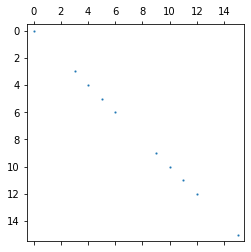

In [5]:
#physical parameters random
J=1.
lamb=0.
g=1.
#test the circuit for 4 qubits
nq=4
#initialize the class that gives the XY Hamiltonian in sparse matrix
Hamtest=XY1D(nq,J,g,lamb)
Hamtest.XY1D_getH()
Hamspar=Hamtest.XYHam
#initialize the class that gives the XY diagonalizing circuit#initialize the class that gives the XY diagonalizing circuit
XYtest=QsimXY1D(nq,J,g,lamb)
#save the circuit
qcXY=XYtest.XY1Dqc
#pass to spar matrix
qcXYspar=csr_matrix(qcXY.unitary())
#compute the invers matrix
qcXYsparinv=inv(qcXYspar)
#diagonalize the Hamiltonian
Diag_in=(Hamspar.tocsc()).dot(qcXYsparinv.tocsc())
Diadf=qcXYspar.dot(Diag_in.tocsc())
#round the 10th decimal
b=np.round(Diadf.toarray(),10)
#print the elements
print(csr_matrix(b))
#do a plot of the elements
plt.spy(csr_matrix(b), markersize=1)
#print the random values
print(J,lamb,g)

In [6]:
#Circuit to prepare the different ground states:

# Function vect1011: 
    #Function that creates a circuit which converts the |0000> to |1011>

#inputs:
    #nq --> number of Qbits in our circuit 
    
#outputs: 
    #qc --> returns a circuit where the |0000> become |1011>
    
def vect0100(nq):
    #initialize the circuit with nq qbits
    qc=models.Circuit(nq)
    #apply the X gates in 0,2,and 3
    qc.add((gates.X(1)))
    #return the final circit
    return qc


#_______________________________________________________________________________________________________________________________

# Function vect1111: 
    #Function that creates a circuit which converts the |0000> to |1111>

#inputs:
    #nq --> number of Qbits in our circuit 
    
#outputs: 
    #qc --> returns a circuit where the |0000> become |1111>
    
def vect0000(nq):
    #initialize the circuit with nq qbits
    qc=models.Circuit(nq)
    return qc


In [7]:
#convert the pauli string we want to measure to a circuit and 
def expauli(Paulistr,qc):
    count=0
    qpos=[]
    for op in Paulistr:
        if op=='I':
            count+=1
            continue
        if op=='X':
            qc.add(gates.H(count))
        if op=='Y':
            qc.add(gates.S(count).dagger())
            qc.add(gates.H(count))
        if op=='Z':
            pass
        qpos.append(count)
        count+=1       
    return qpos

def expectop(qpos,frec):
    key=frec.keys()
    value=list(frec.values())
    probability=[]
    expectval=[]
    Ntot=sum(value)
    count=0
    result=0
    for i in key:
        product=1
        for j in qpos:
            #if the qbit is in the 0 state sum the freq. to N0 
            if int(i[j])==0:
                product=product*1
            #if not the state will be 1.Then sum the freq. to N1
            if int(i[j])==1:
                product=product*(-1)
        result+=product*(float(value[count])/Ntot)
        count+=1
    #calcular error
    #variable which will sum the difference between the expected magnetization of 1 state with the total magnetization
    resta=0
    count=0
    for i in key:
        Ni=value[count]
        producti=1
        for j in qpos:
            #if the qbit is in the 0 state sum the freq. to N0 
            if int(i[j])==0:
                producti=producti*1
            #if not the state will be 1.Then sum the freq. to N1
            if int(i[j])==1:
                producti=producti*(-1)
        #calculate the variance
        resta+=(((float(producti)-result))**2)*Ni
        #sum one to count
        count+=1
    #final variance value
    sigma=np.sqrt(resta)/np.sqrt(float(Ntot-1))
    #return the aleatory error
    error=sigma/np.sqrt(float(Ntot))
    return result,error
    


In [8]:
def energy_Ek(J,l,g,k):
    pi=np.pi
    Ek=np.sqrt((l+J*np.cos(2*pi*k/4.))**2+(J*g*np.sin(2*pi*k/4.))**2)
    epsk=l+J*np.cos(2*pi*k/4.)
    return Ek,epsk
def time_qc(J,l,g,t):
    E0,eps0=energy_Ek(J,l,g,0)
    E1,eps1=energy_Ek(J,l,g,1)
    E1_,eps1_=energy_Ek(J,l,g,-1)
    E2,eps2=energy_Ek(J,l,g,2)
    
    phi0=-2*t*E0
    teta0=-2*t*(-E0+eps0-l)
    phi1=-2*t*E1
    teta1=-2*t*(-E1+eps1-l)
    phi1_=-2*t*E1_
    teta1_=-2*t*(-E1_+eps1_-l)
    phi2=-2*t*E2
    teta2=-2*t*(-E2+eps2-l)
    
    
    
    
    qc=Circuit(4)
    qc.add(gates.U1(0,phi0))
    qc.add(gates.U1(0,teta0/2.))
    qc.add(gates.X(0))
    qc.add(gates.U1(0,teta0/2.))
    
    qc.add(gates.U1(1,phi2))
    qc.add(gates.U1(1,teta2/2.))
    qc.add(gates.X(1))
    qc.add(gates.U1(1,teta2/2.))
    
    qc.add(gates.U1(2,phi1))
    qc.add(gates.U1(2,teta1/2.))
    qc.add(gates.X(2))
    qc.add(gates.U1(2,teta1/2.))
    
    qc.add(gates.U1(3,phi1_))
    qc.add(gates.U1(3,teta1_/2.))
    qc.add(gates.X(3))
    qc.add(gates.U1(3,teta1_/2.))
    
    return qc
    
    

In [9]:
Hamilton3=['ZIII','IZII','IIZI','IIIZ']
sol3=0


nq=4
J=1.
g=1.
n=4
l=0.5
#set all the possible lambdas
time=np.arange(0,2.1,0.1)
#empty list to add the computet values for M an error M
Elist0=[]
errlist0=[]
energy0=0
analit0=[]
#number of times the experiment is run
shots=1000
#calculate for different lambdas:
for t in time:
    #circuit to set the initial vector
    iniqc0=vect0000(nq)
    #initialize the class that gives the XY diagonalizing circuit#initialize the class that gives the XY diagonalizing circuit
    XYtest=QsimXY1D(nq,J,g,l)
    #save the circuit
    qcXY=XYtest.XY1Dqc
    #XYmodel circuit:
    qcXY4=qcXY.invert()
    QC_evol=time_qc(J,l,g,t)
    QC_tot=qcXY+QC_evol+qcXY4
    energy0=0
    error0=0
    analit0.append((1.+2.*l**2 +np.cos(4.*t*np.sqrt(1.+l**2)))/(2.+2.*l**2))
    for h in Hamilton3:
        qc= QC_tot.copy()
        qpos=expauli(h,qc)
        qc.add(gates.M(0,1,2,3))
        result0=qc(initial_state=iniqc0,nshots=shots)
        frec0=result0.frequencies(binary=True)
        energ,error=expectop(qpos,frec0)
        energy0+=energ
        error0+=error
    
    Elist0.append(np.abs(energy0/4.))
    errlist0.append(np.abs(error0/4.))
    



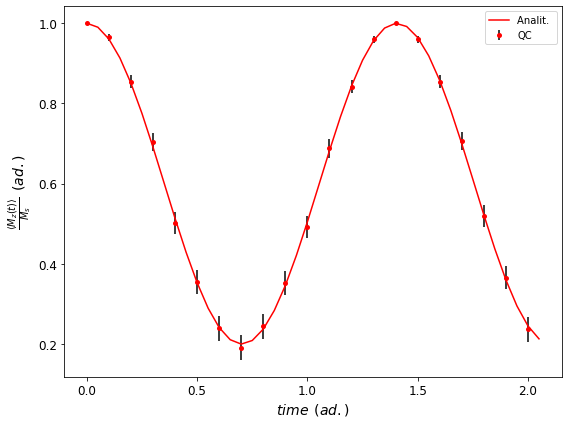

In [10]:
import numpy as np
import matplotlib.pyplot as plt

# Create the figure and axis with a larger size
fig, ax = plt.subplots(figsize=(8, 6))  # Adjust width and height as desired

# Define the analytical function
time2 = np.arange(0, 2.1, 0.05)
analit2 = (1. + 2. * l ** 2 + np.cos(4. * time2 * np.sqrt(1. + l ** 2))) / (2. + 2. * l ** 2)

# Plot the analytical values
plt.errorbar(time, Elist0, yerr=errlist0, fmt="ro", markersize=3, markeredgewidth=2, label='QC', ecolor='black')
plt.plot(time2, analit2, 'r-', label='Analit. ')

# Set labels and legend
plt.xlabel(r"$time \:\: (ad.)$", fontsize=14)
plt.ylabel(r"$ \frac{ \langle M_{z}(t) \rangle }{M_{s}} \:\: (ad.)$", fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=12)  # Adjust labelsize as desired
plt.legend()

# Save the plot with proper margins
plt.tight_layout()  # Adjusts subplot parameters to give specified padding
plt.savefig('Mag_evol_GEFES_n4.png')
plt.show()
